In [2]:
pip install wfdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 3.7 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import wfdb
import ast

In [4]:
import os

In [5]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(os.path.join(path,f)) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(os.path.join(path,f)) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

In [6]:
path='/kaggle/input/ecg-data/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/'
sampling_rate=100

# load and convert annotation data
Y = pd.read_csv(os.path.join(path,'ptbxl_database.csv'), index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))


In [7]:
Y.scp_codes 

ecg_id
1                 {'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}
2                             {'NORM': 80.0, 'SBRAD': 0.0}
3                               {'NORM': 100.0, 'SR': 0.0}
4                               {'NORM': 100.0, 'SR': 0.0}
5                               {'NORM': 100.0, 'SR': 0.0}
                               ...                        
21833    {'NDT': 100.0, 'PVC': 100.0, 'VCLVH': 0.0, 'ST...
21834             {'NORM': 100.0, 'ABQRS': 0.0, 'SR': 0.0}
21835                           {'ISCAS': 50.0, 'SR': 0.0}
21836                           {'NORM': 100.0, 'SR': 0.0}
21837                           {'NORM': 100.0, 'SR': 0.0}
Name: scp_codes, Length: 21799, dtype: object

In [8]:
Y.scp_codes.shape

(21799,)

In [9]:
X = load_raw_data(Y, sampling_rate, path)

In [10]:
agg_df = pd.read_csv(os.path.join(path,'scp_statements.csv'), index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]


In [11]:
def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

In [12]:
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

In [13]:
test_fold = 10

X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass

X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass

In [14]:
X_train.shape

(19601, 1000, 12)

In [15]:
y_train.head

<bound method NDFrame.head of ecg_id
1        [NORM]
2        [NORM]
3        [NORM]
4        [NORM]
5        [NORM]
          ...  
21833    [STTC]
21834    [NORM]
21835    [STTC]
21836    [NORM]
21837    [NORM]
Name: diagnostic_superclass, Length: 19601, dtype: object>

In [16]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 19601 entries, 1 to 21837
Series name: diagnostic_superclass
Non-Null Count  Dtype 
--------------  ----- 
19601 non-null  object
dtypes: object(1)
memory usage: 306.3+ KB


In [17]:
np.unique(y_train).shape[0]

25

In [18]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y_train_encoded = pd.DataFrame(mlb.fit_transform(y_train), columns=mlb.classes_)

In [19]:
y_train_encoded.shape

(19601, 5)

In [20]:
y_train_encoded.head()

,CD,HYP,MI,NORM,STTC
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,0,0,1,0


In [21]:
type(y_train_encoded)

pandas.core.frame.DataFrame

In [22]:
y_train_encoded['final_output']=y_train_encoded.apply(lambda x:''.join(x.astype(str)),axis=1)

In [23]:
y_train_encoded.head()

,CD,HYP,MI,NORM,STTC,final_output
0,0,0,0,1,0,00010
1,0,0,0,1,0,00010
2,0,0,0,1,0,00010
3,0,0,0,1,0,00010
4,0,0,0,1,0,00010


In [24]:
y_train_encoded['final_output'].nunique()

22

In [25]:
y_train_encoded['final_output'].unique()

array(['00010', '00100', '00000', '00001', '01000', '10000', '00101',
       '11000', '10100', '10001', '01100', '01101', '01001', '10101',
       '10010', '11101', '11001', '00011', '11100', '10011', '01010',
       '11110'], dtype=object)

In [26]:
def adjust_classes(y_train):
    var=y_train
    if var == '00010':
        var=0
    elif var == '00100':
        var =1
    elif var== '00000':
        var=2
    elif var=='00001':
        var =3
    elif var =='01000':
        var=4
    elif var=='10000':
        var =5
    elif var =='00101':
        var =6
    elif var =='11000':
        var=7
    elif var =='10100':
        var=8
    elif var=='10001':
        var =9
    elif var =='01100':
        var =10
    elif var =='01101':
        var =11
    elif var=='01001':
        var=21
    elif var =='10101':
        var=12
    elif var =='10010':
        var=13
    elif var=='11101':
        var=14
    elif var=='11001':
        var=15
    elif var =='00011':
        var=16
    elif var=='11100':
        var=17
    elif var=='10011':
        var=18
    elif var =='01010':
        var=19
    elif var=='11110':
        var=20
    return var

In [27]:
y_train_encoded['final_output']=y_train_encoded['final_output'].apply(adjust_classes)

In [28]:
y_train_encoded

,CD,HYP,MI,NORM,STTC,final_output
0,0,0,0,1,0,0
1,0,0,0,1,0,0
2,0,0,0,1,0,0
3,0,0,0,1,0,0
4,0,0,0,1,0,0
...,...,...,...,...,...,...
19596,0,0,0,0,1,3
19597,0,0,0,1,0,0
19598,0,0,0,0,1,3
19599,0,0,0,1,0,0


In [29]:
y_train_encoded['final_output'].value_counts()

final_output
0     8157
1     2276
3     2158
5     1524
8     1164
21     708
6      538
4      479
9      433
2      371
13     362
11     320
7      273
12     202
15     186
10     166
14     140
17     112
16      24
18       5
19       2
20       1
Name: count, dtype: int64

In [31]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

In [32]:
x_train_normalization=X_train.reshape(-1,1000*12)

In [33]:
x_train=scaler.fit_transform(x_train_normalization)
x_train_normalized=x_train.reshape(19601,1000,12)

In [34]:
class_distribution_norm=y_train_encoded['NORM'].value_counts()

In [35]:
class_distribution_cd=y_train_encoded['CD'].value_counts()

In [36]:
class_distribution_hyp=y_train_encoded['HYP'].value_counts()

In [37]:
class_distribution_mi=y_train_encoded['MI'].value_counts()

In [38]:
class_distribution_sttc=y_train_encoded['STTC'].value_counts()

In [39]:
indices_0 = np.where(y_train_encoded['NORM'] == 0)[0] 
indices_1 = np.where(y_train_encoded['NORM'] == 1)[0]
selected_indices_0=np.random.choice(indices_0, 4000, replace=False)
selected_indices_1=np.random.choice(indices_1, 4000, replace=False)
x_train_norm0=X_train[selected_indices_0]
x_train_norm1=X_train[selected_indices_1]
y_train_norm0=y_train_encoded.iloc[selected_indices_0,3]
y_train_norm1=y_train_encoded.iloc[selected_indices_1,3]
x_train= np.concatenate([x_train_norm0, x_train_norm1], axis=0)
y_train=np.concatenate([y_train_norm0, y_train_norm1], axis=0)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


I0000 00:00:1731785595.119761     149 service.cc:145] XLA service 0x786c4f6badc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731785595.119834     149 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731785595.119841     149 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 3/80 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.5938 - loss: 1.1906 

I0000 00:00:1731785602.303386     149 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.7470 - loss: 0.8766 - val_accuracy: 0.7437 - val_loss: 0.8328
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.7986 - loss: 0.6355 - val_accuracy: 0.7250 - val_loss: 0.7810
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.8410 - loss: 0.5336 - val_accuracy: 0.7375 - val_loss: 0.6803
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.8620 - loss: 0.4790 - val_accuracy: 0.7234 - val_loss: 0.6675
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.8511 - loss: 0.4388 - val_accuracy: 0.8000 - val_loss: 0.5091
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.8618 - loss: 0.4126 - val_accuracy: 0.8422 - val_loss: 0.4325
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.8637 - loss: 0.4048 - val_accuracy: 0.8687 - val_loss: 0.3602
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.8690 - loss: 0.3789 - val_accuracy: 0.8391 - val_

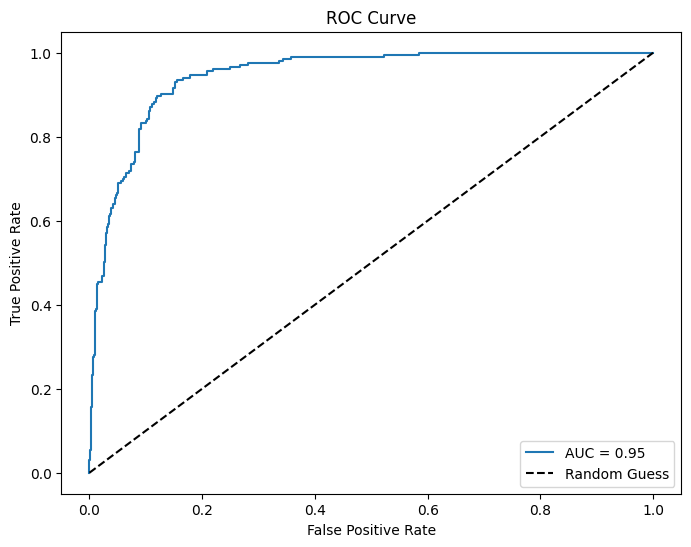

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 1000, 12, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 1000, 12, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 1000, 12, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 500, 6, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 500, 6, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 500, 6, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 500, 6, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 250, 3, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 250, 3, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 250, 3, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 250, 3, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 125, 1, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,409,029 (5.38 MB)

 Trainable params: 469,377 (1.79 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 938,756 (3.58 MB)

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

def create_ecg_2d_cnn_model(input_shape):
    model = models.Sequential()

    # Convolutional Layers
    model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation=None, padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation=None, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), activation=None, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Global Pooling
    model.add(layers.GlobalAveragePooling2D())

    # Dense Layers
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dropout(0.5))

    # Output Layer
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

def evaluate_model(model, x_test, y_test):
    # Predict probabilities and classes
    y_pred_probs = model.predict(x_test).flatten()
    y_pred_classes = (y_pred_probs > 0.5).astype(int)

    # Compute metrics
    auc_score = roc_auc_score(y_test, y_pred_probs)
    cm = confusion_matrix(y_test, y_pred_classes)
    report = classification_report(y_test, y_pred_classes)

    # Display metrics
    print("Confusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(report)
    print(f"\nAUC-ROC Score: {auc_score:.2f}")

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# Example usage with your data
input_shape = (1000, 12, 1)
x_train, x_test, y_train, y_test = train_test_split(
        x_train, y_train, test_size=0.2, random_state=42
    )

# Reshape data
x_train_reshaped = x_train.reshape((x_train.shape[0], 1000, 12, 1))
x_test_reshaped = x_test.reshape((x_test.shape[0], 1000, 12, 1))

# Create the model
model = create_ecg_2d_cnn_model(input_shape)

# Add Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    x_train_reshaped, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
evaluate_model(model, x_test_reshaped, y_test)

# Display model summary
model.summary()


Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.6922 - loss: 0.9364 - val_accuracy: 0.6602 - val_loss: 0.9433
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.8070 - loss: 0.5955 - val_accuracy: 0.7898 - val_loss: 0.6121
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.8323 - loss: 0.5100 - val_accuracy: 0.8258 - val_loss: 0.4656
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.8478 - loss: 0.4340 - val_accuracy: 0.8477 - val_loss: 0.4227
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.8607 - loss: 0.3900 - val_accuracy: 0.7617 - val_loss: 0.5818
Epoch 6/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.8559 - loss: 0.3901 - val_accuracy: 0.7875 - val_loss: 0.4852
Epoch 7/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.8640 - loss: 0.3671 - val_accuracy: 0.7969 - val_loss: 0.4513
Epoch 8/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.8735 - loss: 0.3440 -

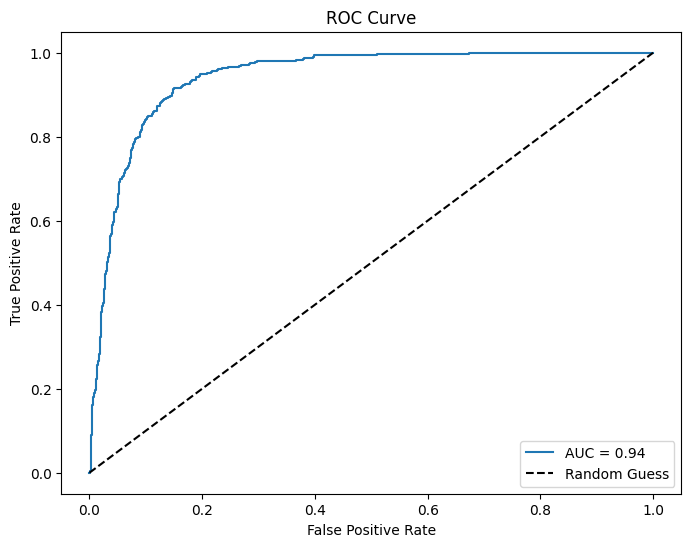

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 1000, 12, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 1000, 12, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 1000, 12, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 500, 6, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 500, 6, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 500, 6, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 500, 6, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 250, 3, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 250, 3, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 250, 3, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 250, 3, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 125, 1, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,409,029 (5.38 MB)

 Trainable params: 469,377 (1.79 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 938,756 (3.58 MB)

In [56]:
indices_0 = np.where(y_train_encoded['CD'] == 0)[0] 
indices_1 = np.where(y_train_encoded['CD'] == 1)[0]
selected_indices_0=np.random.choice(indices_0, 4000, replace=False)
selected_indices_1=np.random.choice(indices_1, 4000, replace=False)
x_train_norm0=X_train[selected_indices_0]
x_train_norm1=X_train[selected_indices_1]
y_train_norm0=y_train_encoded.iloc[selected_indices_0,3]
y_train_norm1=y_train_encoded.iloc[selected_indices_1,3]
x_train= np.concatenate([x_train_norm0, x_train_norm1], axis=0)
y_train=np.concatenate([y_train_norm0, y_train_norm1], axis=0)
input_shape = (1000, 12, 1)
x_train, x_test, y_train, y_test = train_test_split(
        x_train, y_train, test_size=0.2, random_state=42
    )

# Reshape data
x_train_reshaped = x_train.reshape((x_train.shape[0], 1000, 12, 1))
x_test_reshaped = x_test.reshape((x_test.shape[0], 1000, 12, 1))

# Create the model
model = create_ecg_2d_cnn_model(input_shape)

# Add Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    x_train_reshaped, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
evaluate_model(model, x_test_reshaped, y_test)

# Display model summary
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.7287 - loss: 0.8677 - val_accuracy: 0.7039 - val_loss: 0.8987
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.8310 - loss: 0.5761 - val_accuracy: 0.7617 - val_loss: 0.6336
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.8554 - loss: 0.4723 - val_accuracy: 0.7367 - val_loss: 0.6194
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.8737 - loss: 0.4146 - val_accuracy: 0.8508 - val_loss: 0.4463
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.8569 - loss: 0.4141 - val_accuracy: 0.8195 - val_loss: 0.4317
Epoch 6/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.8788 - loss: 0.3641 - val_accuracy: 0.8672 - val_loss: 0.3511
Epoch 7/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.8823 - loss: 0.3289 - val_accuracy: 0.8047 - val_loss: 0.5362
Epoch 8/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.8797 - loss: 0.3330 -

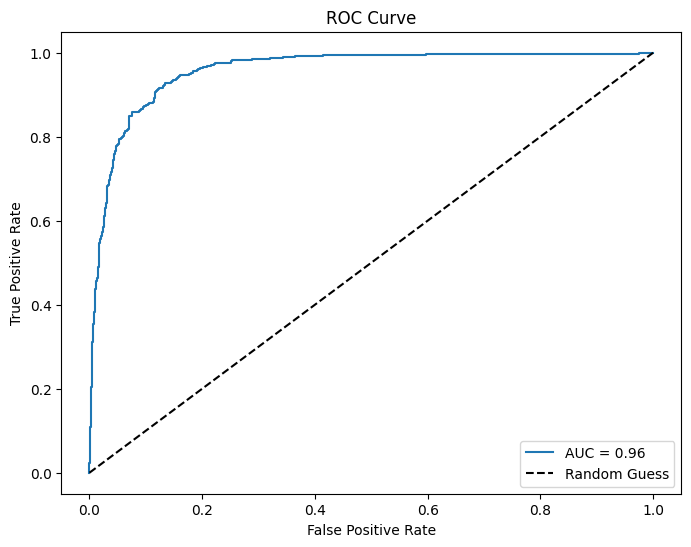

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 1000, 12, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 1000, 12, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 1000, 12, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 500, 6, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 500, 6, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 500, 6, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 500, 6, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 250, 3, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 250, 3, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 250, 3, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_11 (ReLU)                 │ (None, 250, 3, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 125, 1, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,409,029 (5.38 MB)

 Trainable params: 469,377 (1.79 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 938,756 (3.58 MB)

In [57]:
indices_0 = np.where(y_train_encoded['STTC'] == 0)[0] 
indices_1 = np.where(y_train_encoded['STTC'] == 1)[0]
selected_indices_0=np.random.choice(indices_0, 4000, replace=False)
selected_indices_1=np.random.choice(indices_1, 4000, replace=False)
x_train_norm0=X_train[selected_indices_0]
x_train_norm1=X_train[selected_indices_1]
y_train_norm0=y_train_encoded.iloc[selected_indices_0,3]
y_train_norm1=y_train_encoded.iloc[selected_indices_1,3]
x_train= np.concatenate([x_train_norm0, x_train_norm1], axis=0)
y_train=np.concatenate([y_train_norm0, y_train_norm1], axis=0)
input_shape = (1000, 12, 1)
x_train, x_test, y_train, y_test = train_test_split(
        x_train, y_train, test_size=0.2, random_state=42
    )

# Reshape data
x_train_reshaped = x_train.reshape((x_train.shape[0], 1000, 12, 1))
x_test_reshaped = x_test.reshape((x_test.shape[0], 1000, 12, 1))

# Create the model
model = create_ecg_2d_cnn_model(input_shape)

# Add Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    x_train_reshaped, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
evaluate_model(model, x_test_reshaped, y_test)

# Display model summary
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.6867 - loss: 0.9149 - val_accuracy: 0.7195 - val_loss: 0.7761
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.8294 - loss: 0.5610 - val_accuracy: 0.7203 - val_loss: 0.9332
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.8472 - loss: 0.4731 - val_accuracy: 0.8586 - val_loss: 0.4533
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.8557 - loss: 0.4303 - val_accuracy: 0.8180 - val_loss: 0.4587
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.8580 - loss: 0.3976 - val_accuracy: 0.8391 - val_loss: 0.3922
Epoch 6/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.8636 - loss: 0.3774 - val_accuracy: 0.8578 - val_loss: 0.3559
Epoch 7/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.8678 - loss: 0.3558 - val_accuracy: 0.8594 - val_loss: 0.3432
Epoch 8/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.8617 - loss: 0.3513 -

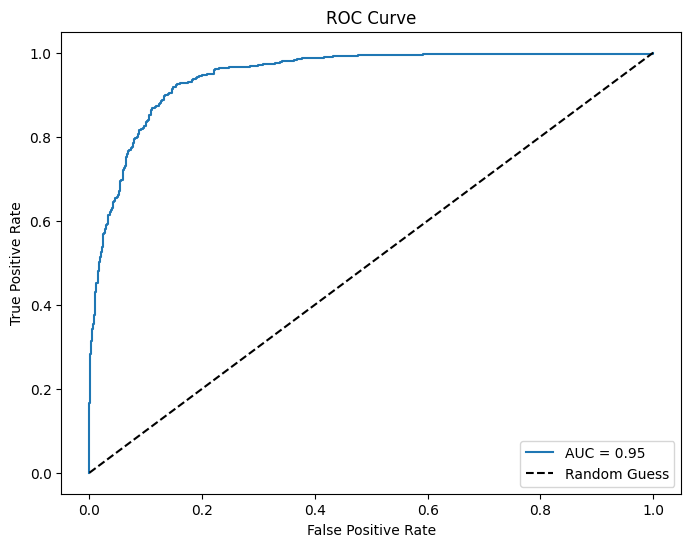

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 1000, 12, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 1000, 12, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_12 (ReLU)                 │ (None, 1000, 12, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 500, 6, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 500, 6, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 500, 6, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_13 (ReLU)                 │ (None, 500, 6, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 250, 3, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 250, 3, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 250, 3, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_14 (ReLU)                 │ (None, 250, 3, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 125, 1, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,409,029 (5.38 MB)

 Trainable params: 469,377 (1.79 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 938,756 (3.58 MB)

In [58]:
indices_0 = np.where(y_train_encoded['MI'] == 0)[0] 
indices_1 = np.where(y_train_encoded['MI'] == 1)[0]
selected_indices_0=np.random.choice(indices_0, 4000, replace=False)
selected_indices_1=np.random.choice(indices_1, 4000, replace=False)
x_train_norm0=X_train[selected_indices_0]
x_train_norm1=X_train[selected_indices_1]
y_train_norm0=y_train_encoded.iloc[selected_indices_0,3]
y_train_norm1=y_train_encoded.iloc[selected_indices_1,3]
x_train= np.concatenate([x_train_norm0, x_train_norm1], axis=0)
y_train=np.concatenate([y_train_norm0, y_train_norm1], axis=0)
input_shape = (1000, 12, 1)
x_train, x_test, y_train, y_test = train_test_split(
        x_train, y_train, test_size=0.2, random_state=42
    )

# Reshape data
x_train_reshaped = x_train.reshape((x_train.shape[0], 1000, 12, 1))
x_test_reshaped = x_test.reshape((x_test.shape[0], 1000, 12, 1))

# Create the model
model = create_ecg_2d_cnn_model(input_shape)

# Add Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    x_train_reshaped, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
evaluate_model(model, x_test_reshaped, y_test)

# Display model summary
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.7341 - loss: 0.9020 - val_accuracy: 0.4406 - val_loss: 0.9461
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.8274 - loss: 0.6336 - val_accuracy: 0.7594 - val_loss: 0.7304
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.8333 - loss: 0.5446 - val_accuracy: 0.7578 - val_loss: 0.6331
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.8375 - loss: 0.5230 - val_accuracy: 0.7750 - val_loss: 0.5276
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.8441 - loss: 0.4608 - val_accuracy: 0.8313 - val_loss: 0.4915
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.8553 - loss: 0.4314 - val_accuracy: 0.8453 - val_loss: 0.4487
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.8566 - loss: 0.4166 - val_accuracy: 0.8766 - val_loss: 0.3925
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.8830 - loss: 0.3626 - val_accuracy: 0

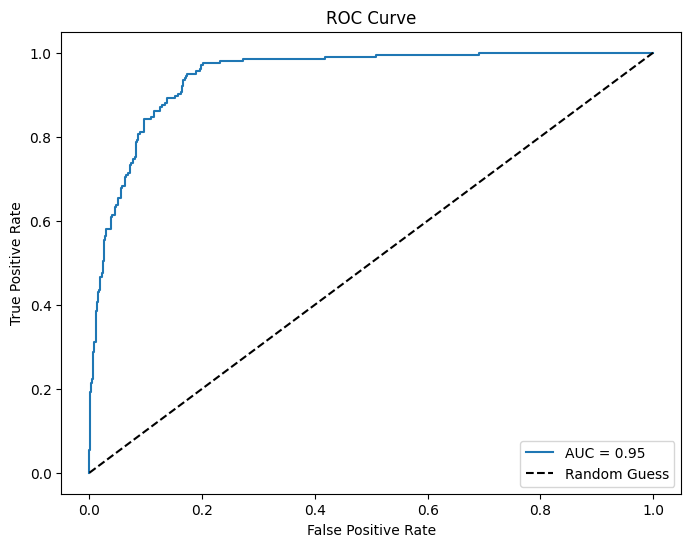

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 1000, 12, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 1000, 12, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_15 (ReLU)                 │ (None, 1000, 12, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 500, 6, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 500, 6, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 500, 6, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_16 (ReLU)                 │ (None, 500, 6, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 250, 3, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 250, 3, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 250, 3, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_17 (ReLU)                 │ (None, 250, 3, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 125, 1, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,409,029 (5.38 MB)

 Trainable params: 469,377 (1.79 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 938,756 (3.58 MB)

In [59]:
indices_0 = np.where(y_train_encoded['HYP'] == 0)[0] 
indices_1 = np.where(y_train_encoded['HYP'] == 1)[0]
selected_indices_0=np.random.choice(indices_0, 2000, replace=False)
selected_indices_1=np.random.choice(indices_1, 2000, replace=False)
x_train_norm0=X_train[selected_indices_0]
x_train_norm1=X_train[selected_indices_1]
y_train_norm0=y_train_encoded.iloc[selected_indices_0,3]
y_train_norm1=y_train_encoded.iloc[selected_indices_1,3]
x_train= np.concatenate([x_train_norm0, x_train_norm1], axis=0)
y_train=np.concatenate([y_train_norm0, y_train_norm1], axis=0)
input_shape = (1000, 12, 1)
x_train, x_test, y_train, y_test = train_test_split(
        x_train, y_train, test_size=0.2, random_state=42
    )

# Reshape data
x_train_reshaped = x_train.reshape((x_train.shape[0], 1000, 12, 1))
x_test_reshaped = x_test.reshape((x_test.shape[0], 1000, 12, 1))

# Create the model
model = create_ecg_2d_cnn_model(input_shape)

# Add Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    x_train_reshaped, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
evaluate_model(model, x_test_reshaped, y_test)

# Display model summary
model.summary()